# Contents :
**Part 0 : Environnement Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset Import</a>
 
**Part 1 : EnergyUse Prediction without EnergyStarScore**
 - <a href="#C4">Dummy and Baseline</a>
 - <a href="#C5">Modeling</a>
 - <a href="#C6">Best model</a>
  
**Part 2 : EnergyUse Prediction with EnergyStarScore**
 - <a href="#C7">Dummy and Baseline</a>
 - <a href="#C8">Modeling</a>
 - <a href="#C9">Best model</a>
 
**Part 3 : Impact of EnergyStarScore**
 - <a href="#C10">EnergyUse prediction</a>
 - <a href="#C11">GHGEmissions prediction</a>

# Part 0 : Environnement Setup

# <a name="C1">Importation of libraries</a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import statsmodels.api as sm
import datetime as dt
import scipy.stats as st
import sklearn as skl
from matplotlib.collections import LineCollection
import missingno as msno
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import math
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Displaying versions of libraries
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)
print("scikit-learn version : " + skl.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2
scikit-learn version : 1.0.2


# <a name="C2">Definition of functions</a>

In [3]:
def correlation(dataset, threshold):
    '''Correlation function that returns columns with a correlation greater than a threshold'''
        
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [4]:
def preprocessing(X, y, dataset):
    '''Pre-processing function that returns for a given dataset, the result of the different pre-processing on the 5 estimators with param by default'''
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

    estimator_list = [LinearRegression(), SVR(), KNeighborsRegressor(), RandomForestRegressor(), XGBRegressor()]        

    scaler_list = ["passthrough", StandardScaler(), RobustScaler(), QuantileTransformer(n_quantiles=100), QuantileTransformer(n_quantiles=200)] 

    polynomial_list = ["passthrough",PolynomialFeatures(degree = 1), PolynomialFeatures(degree = 2)]

    pca_list = ["passthrough",PCA(n_components = 2),PCA(n_components = 3),PCA(n_components = 4)]

    param_grid = {
        'scaler' : scaler_list,
        'polynomial' : polynomial_list,
        'pca' : pca_list, 
        'estimator' : estimator_list
    }

    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('polynomial', PolynomialFeatures(degree = 1)),
        ('pca', PCA(n_components = 4)),
        ('estimator', RandomForestRegressor())
    ])

    grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=3)

    grid.fit(X_train, y_train)

    result = pd.DataFrame(grid.cv_results_)
    result['dataset'] = dataset
    result = result[['dataset','params', 'mean_test_score', 'std_test_score','mean_fit_time',
       'rank_test_score']]
    
    return result

In [5]:
'''List of estimators and their hyperparameters to test'''

algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                
            }
        
        },
        'elasticnet' : {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.01,1,5,10]
            }
        },
        'SVR' : {
            'model': SVR(),
            'params': {
                'gamma' : [1e-8, 1e-6, 1e-4, 1e-2], #kernel coefficient [ici kernel = Radial Basis Function]
                'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
                'C' : [0.001, 0.1, 10]
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors' : [7,9,11,13,15]
                
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [300,500,600,800],
                'min_samples_leaf': [1,3,5],
                'max_features': ['auto', 'sqrt']
            }
        },
        'XGBoost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [20,50,100,200]
            }
        }
    }

In [11]:
def optimisation(X_train, y_train, dataset, scaler, poly, algos):
    '''Model optimization function that returns for specific data pre-processing and a set of estimators to test, the best model and its associated parameters'''

    scores = []
    scores = pd.DataFrame(scores, columns=['dataset','scaler','poly','estimator','best_score','best_params','mean_score','std_score','mean_fit_time','MAE','MSE','RMSE','R2'])
    
    for algo_name, config in algos.items():
        # Searching hyperparameters by cross-validation on a set of estimators and associated parameters
        grid = GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False)
        
        # Optimising the estimator on the training dataset
        grid.fit(X_train, y_train)
        
        # Viewing optimal hyperparameters and associated performance
        scores = scores.append({
            'dataset': dataset,
            'scaler': scaler,
            'poly': poly,
            'estimator': config['model'],
            'best_score': grid.best_score_, 
            'best_params': grid.best_params_, 
            'mean_score': grid.cv_results_['mean_test_score'].mean(), 
            'std_score': grid.cv_results_['std_test_score'].mean(), 
            'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
            'RMSE' : mean_squared_error(y_test, grid.predict(X_test)),
            'R2' : r2_score(y_test, grid.predict(X_test))
        },  ignore_index=True)
        
    return scores

# <a name="C3">Dataset Import</a>

In [12]:
# Importing file 
data = pd.read_csv('building-energy-benchmarking-nettoye.csv')

In [13]:
# Displaying file shape
data.shape

(1684, 28)

In [14]:
# Displaying first rows
data.head()

,EnergyUse,EnergyUseWN,GHGEmissions,CouncilDistrictCode,NbofBuildings,NbofFloors,GFAParking,GFABuilding,ENERGYSTARScore,SteamUse,...,Food,Large Office,Leisure,Mixed Use Property,Other,Parking,Retail Store,Services,Small- and Mid-Sized Office,Worship Facility
0,3091559.0,3229387.0,80.49,5,1.0,3.0,0,55442,74.0,0,...,0,0,0,0,0,0,0,0,1,0
1,14583160.0,15302825.0,291.28,5,1.0,2.0,0,244529,57.0,0,...,0,0,0,0,0,0,1,0,0,0
2,14935251.0,15934393.0,143.10,7,1.0,13.0,149326,208933,81.0,0,...,0,1,0,0,0,0,0,0,0,0
3,9213841.0,9213841.0,64.23,7,1.0,5.0,0,168115,79.0,0,...,0,1,0,0,0,0,0,0,0,0
4,40451748.0,0.0,282.01,7,1.0,33.0,0,791396,89.0,0,...,0,1,0,0,0,0,0,0,0,0


In [15]:
# Displaying columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode',
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'ENERGYSTARScore', 'SteamUse', 'GasUse', 'Age', 'FloorGFA',
       'ParkingRatio', '247Essential', '247Nonessential', 'Accommodation',
       'Education', 'Food', 'Large Office', 'Leisure', 'Mixed Use Property',
       'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

# Part 1 : EnergyUse Prediction without EnergyStarScore

# <a name="C4">Dummy and Baseline</a>

In [16]:
# Defining features
X = data.drop(['ENERGYSTARScore','EnergyUse', 'EnergyUseWN', 'GHGEmissions'], axis='columns')

In [17]:
# Defining target
y = data.EnergyUse

In [18]:
# Creating a score dataframe to save models' performances
scores = []
scores = pd.DataFrame(scores, columns=['estimator','MAE','MSE','RMSE','R2'])

In [19]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

In [20]:
# Creating the estimator Dummy
dum = DummyRegressor(strategy='mean')

# Training this estimator on training set
dum.fit(X_train, y_train)

# Displaying performance on test set
y_pred_dum = dum.predict(X_test)
scores = scores.append({
            'estimator': "Dummy",
            'MAE' : metrics.mean_absolute_error(y_test, y_pred_dum),
            'MSE' : metrics.mean_squared_error(y_test, y_pred_dum),
            'RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),
            'R2' : r2_score(y_test, y_pred_dum)
},  ignore_index=True)     

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2319592334.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


In [21]:
# Creating the baseline estimator = simple linear regression 
lin = LinearRegression()

# Training this estimator on training set
lin.fit(X_train, y_train)

# Displaying performance on test set
y_pred_lin = lin.predict(X_test)
scores = scores.append({
            'estimator': lin,
            'MAE' : metrics.mean_absolute_error(y_test, y_pred_dum),
            'MSE' : metrics.mean_squared_error(y_test, y_pred_dum),
            'RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),
            'R2' : r2_score(y_test, y_pred_lin)
},  ignore_index=True)    

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\820389009.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


In [22]:
# Displaying all performances
scores

,estimator,MAE,MSE,RMSE,R2
0,Dummy,6435590.236952,135553716205616.515625,11642753.806794,-0.003093
1,LinearRegression(),6435590.236952,135553716205616.515625,11642753.806794,0.639184


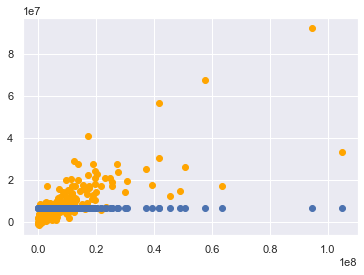

In [23]:
# Comparing prediction on test set and true
plt.scatter(y_test, y_pred_lin, color = "orange")
plt.scatter(y_test, y_pred_dum)
#plt.title(labels=['linear','dummy'])

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


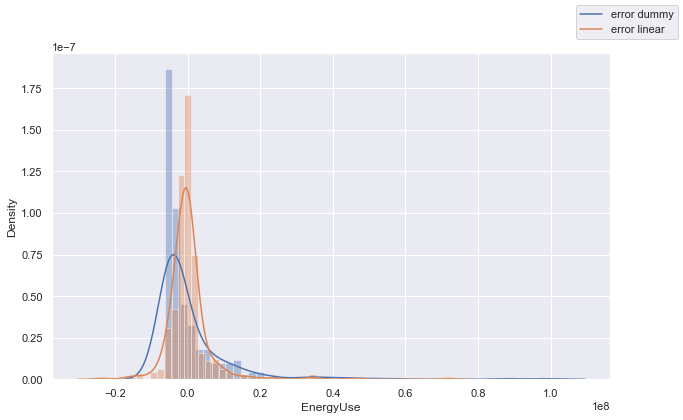

In [24]:
# Comparing models errors
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test - y_pred_dum)
sns.distplot(y_test - y_pred_lin)
fig.legend(labels=['error dummy','error linear'])
plt.show()

In [25]:
# Setting the full display of column/row in a dataframe
pd.set_option('display.max_colwidth', -1)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2484646403.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# <a name="C6">Modeling</a>

## Features Transformation

In [26]:
# Displaying columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode',
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'ENERGYSTARScore', 'SteamUse', 'GasUse', 'Age', 'FloorGFA',
       'ParkingRatio', '247Essential', '247Nonessential', 'Accommodation',
       'Education', 'Food', 'Large Office', 'Leisure', 'Mixed Use Property',
       'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [27]:
# Selecting variables awith values other than 0 and 1.
COL_QUANT = ['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode',
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'ENERGYSTARScore', 'Age', 'FloorGFA',
       'ParkingRatio']

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

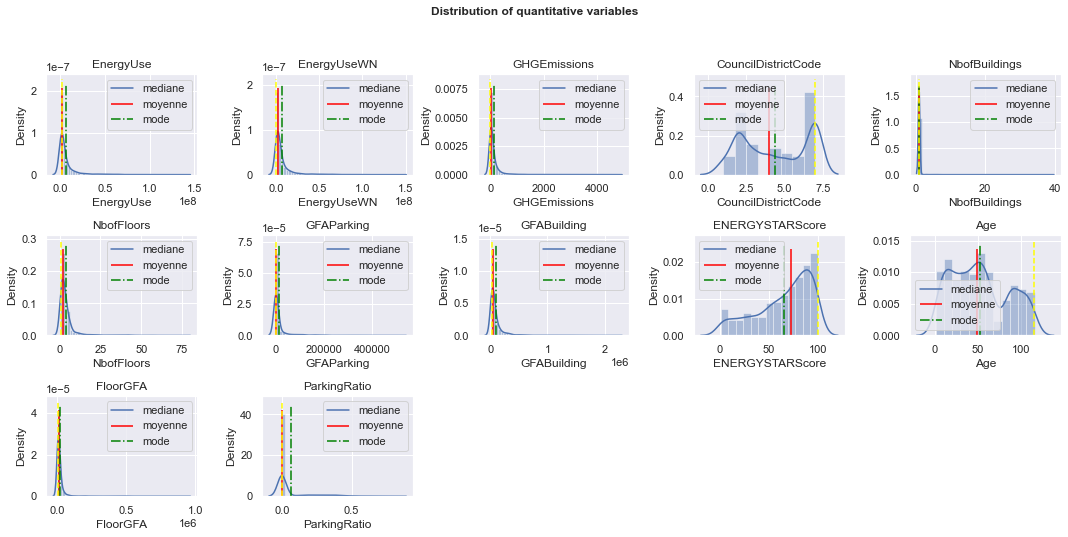

In [28]:
# Analysing order of magnitude for each variable
fig = plt.figure(figsize=(15,8))

for i, col in enumerate(COL_QUANT,1):
    ax = fig.add_subplot(3,5,i)
    #ax.hist(data[col],  bins=100)
    sns.distplot(data[col])
    ax.set_title(col)
    ax.vlines(data[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    ax.vlines(data[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    ax.vlines(data[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    ax.legend(['mediane','moyenne','mode'])

plt.suptitle('Distribution of quantitative variables', fontsize=12,
             fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

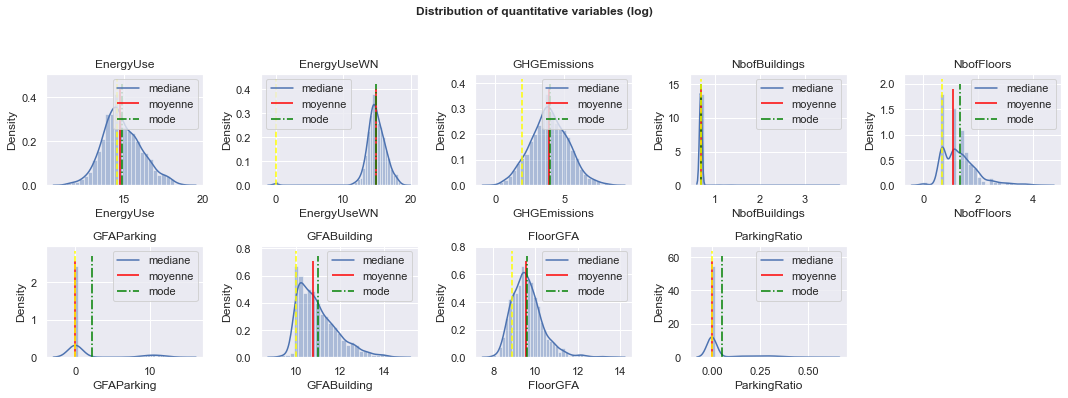

In [29]:
# Analysing log of variables whose distribution has a strong right skewness and unimodal
fig = plt.figure(figsize=(15,8))

for i, col in enumerate(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'FloorGFA',
       'ParkingRatio'],1):
    ax = fig.add_subplot(3,5,i)
    sns.distplot(np.log1p(data[col]))
    ax.set_title(col)
    ax.vlines(np.log1p(data[col]).median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    ax.vlines(np.log1p(data[col]).mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    ax.vlines(np.log1p(data[col]).mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    ax.legend(['mediane','moyenne','mode'])

plt.suptitle('Distribution of quantitative variables (log)', fontsize=12,
             fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

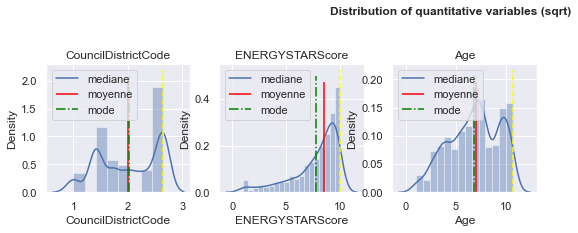

In [30]:
# Analysing of the square root of the other variables
fig = plt.figure(figsize=(15,8))

for i, col in enumerate(['CouncilDistrictCode',
       'ENERGYSTARScore', 'Age'],1):
    ax = fig.add_subplot(3,5,i)
    sns.distplot(np.sqrt(data[col]))
    ax.set_title(col)
    ax.vlines(np.sqrt(data[col]).median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    ax.vlines(np.sqrt(data[col]).mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    ax.vlines(np.sqrt(data[col]).mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    ax.legend(['mediane','moyenne','mode'])

plt.suptitle('Distribution of quantitative variables (sqrt)', fontsize=12,
             fontweight='bold')

plt.show()

## Creating Datasets

In [31]:
# Displaying of columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode',
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'ENERGYSTARScore', 'SteamUse', 'GasUse', 'Age', 'FloorGFA',
       'ParkingRatio', '247Essential', '247Nonessential', 'Accommodation',
       'Education', 'Food', 'Large Office', 'Leisure', 'Mixed Use Property',
       'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [32]:
# Creating dataset 1 - with
# Target : EnergyUse
# Features : all Features except EnergyStarScore
data1 = data.drop(['GHGEmissions','ENERGYSTARScore','EnergyUseWN'], axis='columns')

In [33]:
# Log transforming of all identified features relevant to this transformation
data1['EnergyUseLog'] = np.log1p(data1['EnergyUse'])
data1['NbofBuildingsLog'] = np.log1p(data1['NbofBuildings'])
data1['NbofFloorsLog'] = np.log1p(data1['NbofFloors'])
data1['GFAParkingLog'] = np.log1p(data1['GFAParking'])
data1['GFABuildingLog'] = np.log1p(data1['GFABuilding'])
data1['FloorGFALog'] = np.log1p(data1['FloorGFA'])
data1['ParkingRatioLog'] = np.log1p(data1['ParkingRatio'])

In [34]:
# Checking dataset1 columns
data1.columns

Index(['EnergyUse', 'CouncilDistrictCode', 'NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding', 'SteamUse', 'GasUse', 'Age', 'FloorGFA',
       'ParkingRatio', '247Essential', '247Nonessential', 'Accommodation',
       'Education', 'Food', 'Large Office', 'Leisure', 'Mixed Use Property',
       'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility', 'EnergyUseLog',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog'],
      dtype='object')

In [35]:
# Creating dataset 2 - with 
# Target : EnergyUse
# Features : 4 main quantitative (identified in EDA with strong correlation wwith the target) et linked to PropertyType, except EnergyStarScore
data2 = data.drop(['GHGEmissions','EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode', 'NbofBuildings',
       'ENERGYSTARScore', 'SteamUse', 
       'GasUse', 'Age', 'ParkingRatio'], axis='columns')

In [36]:
# Log transforming of all identified features relevant to this transformation
data2['EnergyUseLog'] = np.log1p(data2['EnergyUse'])
data2['NbofFloorsLog'] = np.log1p(data2['NbofFloors'])
data2['GFABuildingLog'] = np.log1p(data2['GFABuilding'])
data2['GFAParkingLog'] = np.log1p(data2['GFAParking'])
data2['FloorGFALog'] = np.log1p(data2['FloorGFA'])

In [37]:
# Checking dataset2 columns
data2.columns

Index(['EnergyUse', 'NbofFloors', 'GFAParking', 'GFABuilding', 'FloorGFA',
       '247Essential', '247Nonessential', 'Accommodation', 'Education', 'Food',
       'Large Office', 'Leisure', 'Mixed Use Property', 'Other', 'Parking',
       'Retail Store', 'Services', 'Small- and Mid-Sized Office',
       'Worship Facility', 'EnergyUseLog', 'NbofFloorsLog', 'GFABuildingLog',
       'GFAParkingLog', 'FloorGFALog'],
      dtype='object')

## Iteration 1

### Pre-processing

In [38]:
# Defining features
X1A = data1.drop(['EnergyUse','EnergyUseLog','NbofBuildingsLog', 'NbofFloorsLog',
       'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog'], axis='columns')
X1A.columns

Index(['CouncilDistrictCode', 'NbofBuildings', 'NbofFloors', 'GFAParking',
       'GFABuilding', 'SteamUse', 'GasUse', 'Age', 'FloorGFA', 'ParkingRatio',
       '247Essential', '247Nonessential', 'Accommodation', 'Education', 'Food',
       'Large Office', 'Leisure', 'Mixed Use Property', 'Other', 'Parking',
       'Retail Store', 'Services', 'Small- and Mid-Sized Office',
       'Worship Facility'],
      dtype='object')

In [39]:
# Defining target
y1A = data1.EnergyUseLog

In [40]:
# Applying different pre-processings to this dataset on 5 models (without parameters) to identify the "best" pre-processing
result1A = preprocessing(X1A, y1A, "1A")
result1A.sort_values(by='rank_test_score', ascending=True).head(10)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,dataset,params,mean_test_score,std_test_score,mean_fit_time,rank_test_score
183,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': QuantileTransformer(n_quantiles=100)}",0.717583,0.020353,0.750096,1
191,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': StandardScaler()}",0.716945,0.013639,9.326134,2
192,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': RobustScaler()}",0.716913,0.016991,3.912195,3
180,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': 'passthrough'}",0.716223,0.021547,0.737981,4
184,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': QuantileTransformer(n_quantiles=200)}",0.715856,0.022557,0.753325,5
186,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.715200,0.020810,0.762528,6
193,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=100)}",0.714093,0.013078,3.967980,7
182,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.714080,0.018980,0.754732,8
187,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.714004,0.020965,0.847224,9
181,1A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': StandardScaler()}",0.713829,0.018098,0.741046,10


### Models Optimisation

In [41]:
# Applying the pre-processing previously identified to our dataset
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X1A)

scaler = QuantileTransformer(n_quantiles=100)
X_scaled = scaler.fit_transform(X_poly)

In [42]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1A,test_size=0.2, random_state=10)

In [43]:
# Applying the Optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores1A = optimisation(X_train, y_train, "1A", "Quantile100","Poly1", algos)
scores1A.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
4,1A,Quantile100,Poly1,RandomForestRegressor(),0.717928,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 800}",0.706529,0.019857,1.578971,NaN,NaN,0.417015,0.718267
5,1A,Quantile100,Poly1,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.70965,{'n_estimators': 20},0.694812,0.023833,0.148369,NaN,NaN,0.436819,0.704887
0,1A,Quantile100,Poly1,LinearRegression(),0.678808,{},0.678808,0.016458,0.000698,NaN,NaN,0.483677,0.67323
2,1A,Quantile100,Poly1,SVR(),0.675503,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.093111,0.013088,0.060638,NaN,NaN,0.484016,0.673001
1,1A,Quantile100,Poly1,ElasticNet(),0.669675,{'alpha': 0.01},0.16606,0.00615,0.000824,NaN,NaN,0.49265,0.667168
3,1A,Quantile100,Poly1,KNeighborsRegressor(),0.583114,{'n_neighbors': 7},0.571873,0.04137,0.000931,NaN,NaN,0.624842,0.57786


## Iteration 2

### Pre-processing

In [44]:
# Defining features
X1B = data1.drop(['EnergyUse','EnergyUseLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio'], axis='columns')
X1B.columns

Index(['CouncilDistrictCode', 'SteamUse', 'GasUse', 'Age', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog'],
      dtype='object')

In [45]:
# Defining target
y1B = data1.EnergyUseLog

In [46]:
# Applying different pre-processings to this dataset on 5 models (without parameters) to identify the "best" pre-processing
result1B = preprocessing(X1B, y1B, "1B")
result1B.sort_values(by='rank_test_score', ascending=True).head(10)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,dataset,params,mean_test_score,std_test_score,mean_fit_time,rank_test_score
62,1B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.721835,0.022798,0.124675,1
67,1B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.721532,0.022815,0.134232,2
1,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': StandardScaler()}",0.721371,0.018585,0.006270,3
7,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.721371,0.018585,0.010610,4
2,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.721371,0.018585,0.013957,5
6,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.721371,0.018585,0.008928,6
5,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': 'passthrough'}",0.721371,0.018585,0.007868,7
0,1B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': 'passthrough'}",0.721371,0.018585,0.005547,8
192,1B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': RobustScaler()}",0.716557,0.022134,3.594940,9
188,1B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': QuantileTransformer(n_quantiles=100)}",0.716023,0.018882,0.762905,10


### Models Optimisation

In [47]:
# Applying the pre-processing previously identified to our dataset
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X1B)

In [48]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1B,test_size=0.2, random_state=10)

In [49]:
# Applying the Optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores1B = optimisation(X_train, y_train, "1B", "RobustScaler","No transfo", algos)
scores1B.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,1B,RobustScaler,No transfo,SVR(),0.726231,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.15992,0.013163,0.060203,NaN,NaN,0.405819,0.725831
0,1B,RobustScaler,No transfo,LinearRegression(),0.721371,{},0.721371,0.018585,0.001209,NaN,NaN,0.409146,0.723583
4,1B,RobustScaler,No transfo,RandomForestRegressor(),0.718467,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 800}",0.706609,0.020016,1.687757,NaN,NaN,0.413499,0.720642
1,1B,RobustScaler,No transfo,ElasticNet(),0.712634,{'alpha': 0.01},0.235833,0.011483,0.00206,NaN,NaN,0.423121,0.714142
5,1B,RobustScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.710338,{'n_estimators': 20},0.695238,0.024184,0.162428,NaN,NaN,0.437727,0.704274
3,1B,RobustScaler,No transfo,KNeighborsRegressor(),0.679414,{'n_neighbors': 7},0.674589,0.024028,0.001623,NaN,NaN,0.471894,0.681191


## Iteration 3

### Pre-processing

In [50]:
# Displaying columns
data2.columns

Index(['EnergyUse', 'NbofFloors', 'GFAParking', 'GFABuilding', 'FloorGFA',
       '247Essential', '247Nonessential', 'Accommodation', 'Education', 'Food',
       'Large Office', 'Leisure', 'Mixed Use Property', 'Other', 'Parking',
       'Retail Store', 'Services', 'Small- and Mid-Sized Office',
       'Worship Facility', 'EnergyUseLog', 'NbofFloorsLog', 'GFABuildingLog',
       'GFAParkingLog', 'FloorGFALog'],
      dtype='object')

In [51]:
# Defining features
X2A = data2.drop(['EnergyUse','EnergyUseLog','NbofFloorsLog',
       'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog'], axis='columns')
X2A.columns

Index(['NbofFloors', 'GFAParking', 'GFABuilding', 'FloorGFA', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [52]:
# Defining target
y2A = data2.EnergyUseLog

In [53]:
# Applying different pre-processings to this dataset on 5 models (without parameters) to identify the "best" pre-processing
result2A = preprocessing(X2A, y2A, "2A")
result2A.sort_values(by='rank_test_score', ascending=True).head(10)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,dataset,params,mean_test_score,std_test_score,mean_fit_time,rank_test_score
171,2A,"{'estimator': KNeighborsRegressor(), 'pca': PCA(n_components=4), 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.670953,0.023901,0.015776,1
74,2A,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=200)}",0.668995,0.040975,0.239266,2
73,2A,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=100)}",0.668780,0.040826,0.231265,3
191,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': StandardScaler()}",0.666525,0.020314,4.990586,4
192,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': RobustScaler()}",0.665825,0.017565,2.103951,5
190,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': 'passthrough'}",0.665156,0.017768,2.073488,6
194,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=200)}",0.664632,0.021256,2.139159,7
189,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': QuantileTransformer(n_quantiles=200)}",0.663512,0.021241,0.600966,8
183,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': QuantileTransformer(n_quantiles=100)}",0.662875,0.018126,0.723546,9
193,2A,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=100)}",0.662672,0.019108,2.094761,10


### Models Optimisation

In [54]:
# Applying the pre-processing previously identified to our dataset
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X2A)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

In [55]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y2A,test_size=0.2, random_state=10)

In [56]:
# Applying the Optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores2A = optimisation(X_train, y_train, "2A", "StandardScaler","PCA4", algos)
scores2A.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
4,2A,StandardScaler,PCA4,RandomForestRegressor(),0.63031,"{'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}",0.60898,0.044611,1.643116,NaN,NaN,0.556086,0.624311
3,2A,StandardScaler,PCA4,KNeighborsRegressor(),0.609749,{'n_neighbors': 15},0.606359,0.031151,0.00004,NaN,NaN,0.567275,0.616752
5,2A,StandardScaler,PCA4,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.609898,{'n_estimators': 20},0.554708,0.062829,0.141236,NaN,NaN,0.584588,0.605056
2,2A,StandardScaler,PCA4,SVR(),0.582008,"{'C': 10, 'epsilon': 0.001, 'gamma': 0.01}",0.097344,0.01492,0.060268,NaN,NaN,0.599809,0.594772
1,2A,StandardScaler,PCA4,ElasticNet(),0.396579,{'alpha': 0.01},0.137008,0.008147,0.001011,NaN,NaN,0.922624,0.376681
0,2A,StandardScaler,PCA4,LinearRegression(),0.395952,{},0.395952,0.018445,0.001199,NaN,NaN,0.923517,0.376077


## Iteration 4

### Pre-processing

In [57]:
# Defining features
X2B = data2.drop(['EnergyUse','EnergyUseLog','NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA'], axis='columns')
X2B.columns

Index(['247Essential', '247Nonessential', 'Accommodation', 'Education', 'Food',
       'Large Office', 'Leisure', 'Mixed Use Property', 'Other', 'Parking',
       'Retail Store', 'Services', 'Small- and Mid-Sized Office',
       'Worship Facility', 'NbofFloorsLog', 'GFABuildingLog', 'GFAParkingLog',
       'FloorGFALog'],
      dtype='object')

In [58]:
# Defining target
y2B = data2.EnergyUseLog

In [59]:
# Applying different pre-processings to this dataset on 5 models (without parameters) to identify the "best" pre-processing
result2B = preprocessing(X2B, y2B, "2B")
result2B.sort_values(by='rank_test_score', ascending=True).head(10)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,dataset,params,mean_test_score,std_test_score,mean_fit_time,rank_test_score
7,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.700514,0.021758,0.009554,1
0,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': 'passthrough'}",0.700514,0.021758,0.004760,2
1,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': StandardScaler()}",0.700514,0.021758,0.003797,3
6,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.700514,0.021758,0.007992,4
2,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.700514,0.021758,0.005751,5
5,2B,"{'estimator': LinearRegression(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': 'passthrough'}",0.700514,0.021758,0.005094,6
62,2B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.697490,0.027990,0.133532,7
67,2B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.697320,0.027993,0.153675,8
66,2B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.692996,0.037667,0.128735,9
61,2B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': StandardScaler()}",0.692595,0.038041,0.129493,10


### Models Optimisation

In [60]:
# Applying the pre-processing previously identified to our dataset
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X2B)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_poly)

In [61]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y2B,test_size=0.2, random_state=10)

In [62]:
# Applying the Optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores2B = optimisation(X_train, y_train, "2B", "RobustScaler","Poly1", algos)
scores2B.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
4,2B,RobustScaler,Poly1,RandomForestRegressor(),0.695427,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 600}",0.67812,0.018383,1.541347,NaN,NaN,0.430726,0.709004
0,2B,RobustScaler,Poly1,LinearRegression(),0.700514,{},0.700514,0.021758,0.001085,NaN,NaN,0.442858,0.700808
2,2B,RobustScaler,Poly1,SVR(),0.701063,"{'C': 10, 'epsilon': 0.01, 'gamma': 0.01}",0.155988,0.013423,0.064832,NaN,NaN,0.443132,0.700622
1,2B,RobustScaler,Poly1,ElasticNet(),0.696191,{'alpha': 0.01},0.231722,0.01198,0.0019,NaN,NaN,0.449521,0.696306
5,2B,RobustScaler,Poly1,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.694662,{'n_estimators': 20},0.664296,0.029364,0.145747,NaN,NaN,0.469234,0.682988
3,2B,RobustScaler,Poly1,KNeighborsRegressor(),0.667361,{'n_neighbors': 7},0.664975,0.028743,0.000694,NaN,NaN,0.472153,0.681016


# <a name="C9">Best model</a>

In [63]:
# Creating a scores dataframe to save the performance of the models for the 4 iterations
scores = []
scores = pd.DataFrame(scores, columns=['dataset','scaler','poly','estimator','best_score','best_params','mean_score','std_score',
            'mean_fit_time','MAE','MSE','RMSE','R2'])

In [64]:
# Filling this dataframe with the scores of the 4 iterations
scores = scores.append([scores1A, scores1B, scores2A, scores2B])

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1290562616.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append([scores1A, scores1B, scores2A, scores2B])


In [65]:
# Preseting optimisation scores ranked by R2
scores.sort_values(by='R2', ascending=False)

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,1B,RobustScaler,No transfo,SVR(),0.726231,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.15992,0.013163,0.060203,NaN,NaN,0.405819,0.725831
0,1B,RobustScaler,No transfo,LinearRegression(),0.721371,{},0.721371,0.018585,0.001209,NaN,NaN,0.409146,0.723583
4,1B,RobustScaler,No transfo,RandomForestRegressor(),0.718467,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 800}",0.706609,0.020016,1.687757,NaN,NaN,0.413499,0.720642
4,1A,Quantile100,Poly1,RandomForestRegressor(),0.717928,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 800}",0.706529,0.019857,1.578971,NaN,NaN,0.417015,0.718267
1,1B,RobustScaler,No transfo,ElasticNet(),0.712634,{'alpha': 0.01},0.235833,0.011483,0.00206,NaN,NaN,0.423121,0.714142
4,2B,RobustScaler,Poly1,RandomForestRegressor(),0.695427,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 600}",0.67812,0.018383,1.541347,NaN,NaN,0.430726,0.709004
5,1A,Quantile100,Poly1,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.70965,{'n_estimators': 20},0.694812,0.023833,0.148369,NaN,NaN,0.436819,0.704887
5,1B,RobustScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.710338,{'n_estimators': 20},0.695238,0.024184,0.162428,NaN,NaN,0.437727,0.704274
0,2B,RobustScaler,Poly1,LinearRegression(),0.700514,{},0.700514,0.021758,0.001085,NaN,NaN,0.442858,0.700808
2,2B,RobustScaler,Poly1,SVR(),0.701063,"{'C': 10, 'epsilon': 0.01, 'gamma': 0.01}",0.155988,0.013423,0.064832,NaN,NaN,0.443132,0.700622


In [66]:
# Applying the highest ranked pre-processing
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X1B)

In [67]:
# Spliting data in train and test dataset - 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1B,test_size=0.2, random_state=10)

In [68]:
# Creating the highest ranked estimator with its associated hyperparameters
svr = SVR(C= 10, epsilon= 0.1, gamma= 0.01)

# Training this estimator on the training set
svr.fit(X_train, y_train)

SVR(C=10, gamma=0.01)

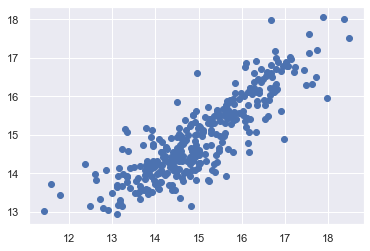

In [69]:
# Comparing the prediction on the test set to the reality
y_pred = svr.predict(X_test)    
plt.scatter(y_test, y_pred)

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


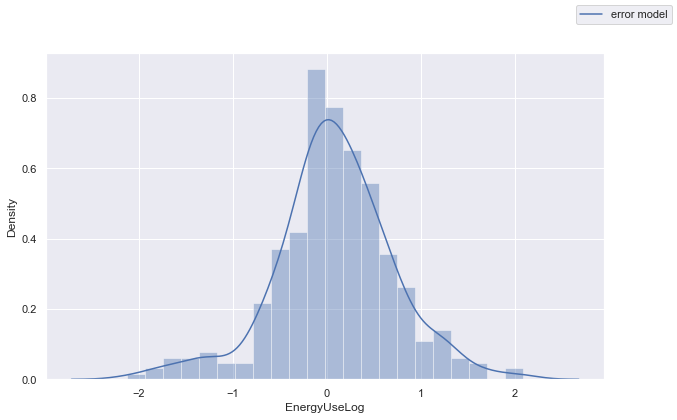

In [70]:
# Visualising model errors
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test - y_pred)
fig.legend(labels=['error model'])
plt.show()

# Part 2 : GHGEmissions Prediction without EnergyStarScore

# <a name="C4">Dummy and Baseline</a>

In [71]:
# Defining features
X = data.drop(['ENERGYSTARScore','EnergyUse', 'EnergyUseWN', 'GHGEmissions'], axis='columns')

In [72]:
# Defining target
y = data.GHGEmissions

In [73]:
# Crating scores dataframe to save models performances 
scores = []
scores = pd.DataFrame(scores, columns=['estimator','MAE','MSE','RMSE','R2'])

In [74]:
# Spliting dataset in training and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

In [75]:
# Creating the estimator Dummy
dum = DummyRegressor(strategy='mean')

# Training this estimaton training set
dum.fit(X_train, y_train)

# Displaying performance on test set
y_pred_dum = dum.predict(X_test)
scores = scores.append({
            'estimator': "Dummy",
            'MAE' : metrics.mean_absolute_error(y_test, y_pred_dum),
            'MSE' : metrics.mean_squared_error(y_test, y_pred_dum),
            'RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),
            'R2' : r2_score(y_test, y_pred_dum)
},  ignore_index=True)     

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1052777168.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


In [76]:
# Creating the Baseline estimator which is simply a simple linear regression
lin = LinearRegression()

# Training this estimaton training set
lin.fit(X_train, y_train)

# Displaying performance on test set
y_pred_lin = lin.predict(X_test)
scores = scores.append({
            'estimator': lin,
            'MAE' : metrics.mean_absolute_error(y_test, y_pred_dum),
            'MSE' : metrics.mean_squared_error(y_test, y_pred_dum),
            'RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)),
            'R2' : r2_score(y_test, y_pred_lin)
},  ignore_index=True)    

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1422194930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


In [77]:
# Displaying all models performances 
scores

,estimator,MAE,MSE,RMSE,R2
0,Dummy,137.859793,85671.701905,292.697287,-0.00388
1,LinearRegression(),137.859793,85671.701905,292.697287,0.357356


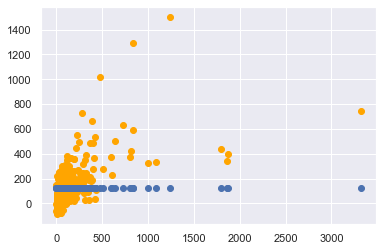

In [78]:
# Comparing prediction on test set to the reality
plt.scatter(y_test, y_pred_lin, color = "orange")
plt.scatter(y_test, y_pred_dum)
#plt.title(labels=['error linear','error dummy'])

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


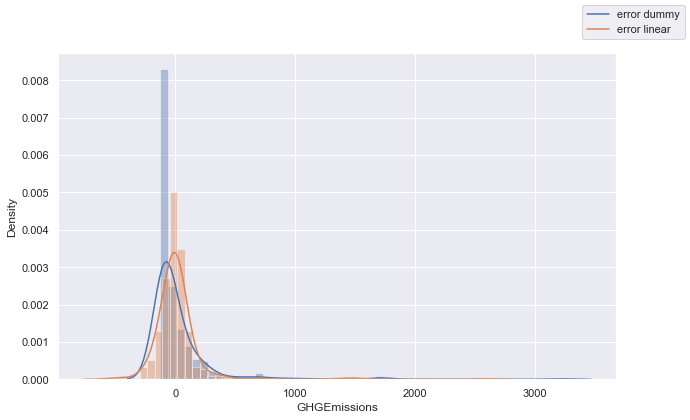

In [79]:
# Comparing models errors
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test - y_pred_dum)
sns.distplot(y_test - y_pred_lin)
fig.legend(labels=['error dummy','error linear'])
plt.show()

# <a name="C6">Modeling</a>

## Creation of the Dataset

In [80]:
# Displaying columns
data.columns

Index(['EnergyUse', 'EnergyUseWN', 'GHGEmissions', 'CouncilDistrictCode',
       'NbofBuildings', 'NbofFloors', 'GFAParking', 'GFABuilding',
       'ENERGYSTARScore', 'SteamUse', 'GasUse', 'Age', 'FloorGFA',
       'ParkingRatio', '247Essential', '247Nonessential', 'Accommodation',
       'Education', 'Food', 'Large Office', 'Leisure', 'Mixed Use Property',
       'Other', 'Parking', 'Retail Store', 'Services',
       'Small- and Mid-Sized Office', 'Worship Facility'],
      dtype='object')

In [81]:
# Creating dataset 3 - dataset adapted to our new target but similar to the best dataset identified for EnergyUse.
# This decision is justified by the strong correlation between these 2 targets.
# Dataset including
# Target : GHGEmissions
# Features : all except EnergyStarScore
data3 = data.drop(['EnergyUse','ENERGYSTARScore','EnergyUseWN'], axis='columns')

In [82]:
# Creating variables transformed into log
data3['GHGEmissionsLog'] = np.log1p(data3['GHGEmissions'])
data3['NbofBuildingsLog'] = np.log1p(data3['NbofBuildings'])
data3['NbofFloorsLog'] = np.log1p(data3['NbofFloors'])
data3['GFAParkingLog'] = np.log1p(data3['GFAParking'])
data3['GFABuildingLog'] = np.log1p(data3['GFABuilding'])
data3['FloorGFALog'] = np.log1p(data3['FloorGFA'])
data3['ParkingRatioLog'] = np.log1p(data3['ParkingRatio'])

### Pre-processing

In [83]:
# Defining features - all features like 1B best dataset for EnergyUse prediction
X3B = data3.drop(['GHGEmissions','GHGEmissionsLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio'], axis='columns')

In [84]:
# Defining target
y3B = data3.GHGEmissionsLog

In [85]:
# Applying different pre-processings to this dataset on 5 models (without parameters) to identify the "best" pre-processing.
result3B = preprocessing(X3B, y3B, "3B")
result3B.sort_values(by='rank_test_score', ascending=True).head(10)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


,dataset,params,mean_test_score,std_test_score,mean_fit_time,rank_test_score
187,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': RobustScaler()}",0.700751,0.029124,0.740392,1
181,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': StandardScaler()}",0.700424,0.029668,0.793157,2
183,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': QuantileTransformer(n_quantiles=100)}",0.698676,0.027429,0.746892,3
193,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(), 'scaler': QuantileTransformer(n_quantiles=100)}",0.697410,0.030840,3.945209,4
62,3B,"{'estimator': SVR(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.696775,0.010343,0.120773,5
184,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': QuantileTransformer(n_quantiles=200)}",0.696672,0.029385,0.761473,6
189,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': QuantileTransformer(n_quantiles=200)}",0.696594,0.033206,0.784250,7
182,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': 'passthrough', 'scaler': RobustScaler()}",0.696577,0.030005,0.776586,8
186,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': StandardScaler()}",0.696552,0.026406,0.738118,9
185,3B,"{'estimator': RandomForestRegressor(), 'pca': 'passthrough', 'polynomial': PolynomialFeatures(degree=1), 'scaler': 'passthrough'}",0.696496,0.031540,0.736169,10


### Models Optimisation

In [86]:
# Applying the pre-processing previously identified to our dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X3B)

In [87]:
# Spliting dataset into train and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y3B,test_size=0.2, random_state=10)

In [88]:
# Applying the optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores3B = optimisation(X_train, y_train, "3B", "StandardScaler","No transfo", algos)
scores3B.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
5,3B,StandardScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.703587,{'n_estimators': 20},0.685571,0.016854,0.160528,NaN,NaN,0.605326,0.680005
2,3B,StandardScaler,No transfo,SVR(),0.718392,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.165877,0.005695,0.059132,NaN,NaN,0.616629,0.67403
4,3B,StandardScaler,No transfo,RandomForestRegressor(),0.70493,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 800}",0.692009,0.018888,1.824698,NaN,NaN,0.617456,0.673593
0,3B,StandardScaler,No transfo,LinearRegression(),0.687772,{},0.687772,0.011063,0.002115,NaN,NaN,0.66381,0.649089
1,3B,StandardScaler,No transfo,ElasticNet(),0.688718,{'alpha': 0.01},0.229254,0.006269,0.002819,NaN,NaN,0.66414,0.648914
3,3B,StandardScaler,No transfo,KNeighborsRegressor(),0.606424,{'n_neighbors': 7},0.584632,0.016271,0.000631,NaN,NaN,0.763216,0.596539


In [89]:
# Creating the highest ranked estimator with its associated hyperparameters
xgb = XGBRegressor(n_estimators = 20)

# Entrainement de cet estimateur sur le jeu d'entraînement
xgb.fit(X_train, y_train)    

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

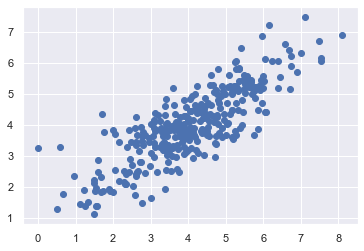

In [90]:
# Comparing the prediction on the test set with reality
y_pred = xgb.predict(X_test) 
plt.scatter(y_test, y_pred)

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


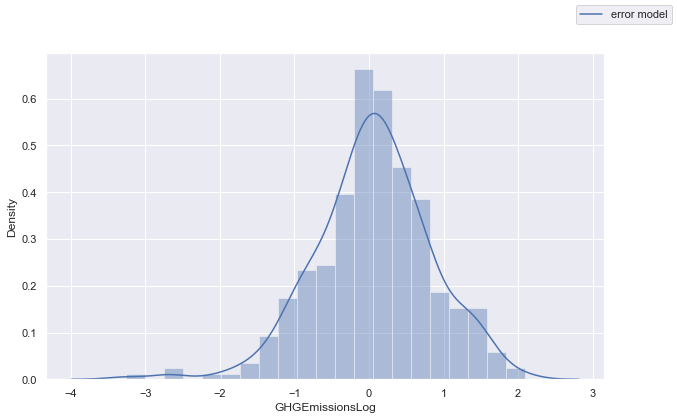

In [91]:
# Displaying errors model
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test - y_pred)
fig.legend(labels=['error model'])
plt.show()

# Part 3 : Impact of EnergyStarScore

In [92]:
# NaNs on variable when adding EnergyStarScore.
data.isna().count()

EnergyUse                      1684
EnergyUseWN                    1684
GHGEmissions                   1684
CouncilDistrictCode            1684
NbofBuildings                  1684
NbofFloors                     1684
GFAParking                     1684
GFABuilding                    1684
ENERGYSTARScore                1684
SteamUse                       1684
GasUse                         1684
Age                            1684
FloorGFA                       1684
ParkingRatio                   1684
247Essential                   1684
247Nonessential                1684
Accommodation                  1684
Education                      1684
Food                           1684
Large Office                   1684
Leisure                        1684
Mixed Use Property             1684
Other                          1684
Parking                        1684
Retail Store                   1684
Services                       1684
Small- and Mid-Sized Office    1684
Worship Facility            

# <a name="C14">EnergyUse Prediction</a>

In [93]:
# Removing rows with NaNs
data4 = data.dropna(subset=['ENERGYSTARScore'])

In [94]:
# Displaying new dataset shape
data4.shape

(1153, 28)

In [95]:
# Applying the log or sqrt transformation to our Data variables
data4['EnergyUseLog'] = np.log1p(data4['EnergyUse'])
data4['NbofBuildingsLog'] = np.log1p(data4['NbofBuildings'])
data4['NbofFloorsLog'] = np.log1p(data4['NbofFloors'])
data4['GFAParkingLog'] = np.log1p(data4['GFAParking'])
data4['GFABuildingLog'] = np.log1p(data4['GFABuilding'])
data4['FloorGFALog'] = np.log1p(data4['FloorGFA'])
data4['ParkingRatioLog'] = np.log1p(data4['ParkingRatio'])
data4['ENERGYSTARScoresq'] = np.sqrt(data4['ENERGYSTARScore'])

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1164776102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['EnergyUseLog'] = np.log1p(data4['EnergyUse'])
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1164776102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['NbofBuildingsLog'] = np.log1p(data4['NbofBuildings'])
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\1164776102.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [96]:
# Creating two datasets - dataset to compare with and without EnergyStarScore given the change in size of the initial dataset
data4AE = data4.drop(['GHGEmissions','EnergyUseWN'], axis='columns')
data4SE = data4.drop(['GHGEmissions','EnergyUseWN','ENERGYSTARScore','ENERGYSTARScoresq'], axis='columns')

In [97]:
# Defining features (with EnergyScore)
X4AE = data4AE.drop(['EnergyUse','EnergyUseLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio','ENERGYSTARScore'], axis='columns')
X4AE.columns

Index(['CouncilDistrictCode', 'SteamUse', 'GasUse', 'Age', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog', 'ENERGYSTARScoresq'],
      dtype='object')

In [98]:
# Defining target
y4AE = data4AE.EnergyUseLog

In [99]:
# Applying the highest ranked pre-processing
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X4AE)

In [100]:
# Spliting dataset into training and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y4AE,test_size=0.2, random_state=10)

In [101]:
# Appliying the optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores4AE = optimisation(X_train, y_train, "4AE", "RobustScaler","No transfo", algos)
scores4AE.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,4AE,RobustScaler,No transfo,SVR(),0.859732,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.17012,0.019701,0.030317,NaN,NaN,0.150133,0.893221
0,4AE,RobustScaler,No transfo,LinearRegression(),0.846951,{},0.846951,0.024761,0.002181,NaN,NaN,0.168426,0.88021
5,4AE,RobustScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.841089,{'n_estimators': 50},0.839575,0.011047,0.133294,NaN,NaN,0.173663,0.876486
1,4AE,RobustScaler,No transfo,ElasticNet(),0.841791,{'alpha': 0.01},0.267935,0.015992,0.00162,NaN,NaN,0.18814,0.866189
4,4AE,RobustScaler,No transfo,RandomForestRegressor(),0.842321,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}",0.821987,0.016862,1.278152,NaN,NaN,0.219113,0.84416
3,4AE,RobustScaler,No transfo,KNeighborsRegressor(),0.791407,{'n_neighbors': 7},0.783804,0.020111,0.000415,NaN,NaN,0.257223,0.817056


In [102]:
# Defining features (wihtout EnergyScore)
X4SE = data4SE.drop(['EnergyUse','EnergyUseLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio'], axis='columns')
X4SE.columns

Index(['CouncilDistrictCode', 'SteamUse', 'GasUse', 'Age', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog'],
      dtype='object')

In [103]:
# Defining target
y4SE = data4SE.EnergyUseLog

In [104]:
# Applying the highest ranked pre-treatment
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X4SE)

In [105]:
# Spliting dataset into training and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y4SE,test_size=0.2, random_state=10)

In [106]:
# Appliying the optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores4SE = optimisation(X_train, y_train, "4SE", "RobustScaler","No transfo", algos)
scores4SE.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,4SE,RobustScaler,No transfo,SVR(),0.773313,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.15518,0.021928,0.028299,NaN,NaN,0.256777,0.817373
5,4SE,RobustScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.758438,{'n_estimators': 20},0.745248,0.049671,0.146203,NaN,NaN,0.269629,0.808232
0,4SE,RobustScaler,No transfo,LinearRegression(),0.764456,{},0.764456,0.043487,0.000453,NaN,NaN,0.277486,0.802644
3,4SE,RobustScaler,No transfo,KNeighborsRegressor(),0.737626,{'n_neighbors': 7},0.73224,0.037053,0.000284,NaN,NaN,0.291291,0.792826
1,4SE,RobustScaler,No transfo,ElasticNet(),0.757304,{'alpha': 0.01},0.246813,0.020104,0.001369,NaN,NaN,0.291936,0.792367
4,4SE,RobustScaler,No transfo,RandomForestRegressor(),0.769826,"{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}",0.757377,0.039998,1.286176,NaN,NaN,0.327974,0.766735


# <a name="C14">GHGEmissions Prediction</a>

In [107]:
# Removing NaN lines
data5 = data.dropna(subset=['ENERGYSTARScore'])

In [108]:
# Applying the log or sqrt transformation to our Data variables
data5['GHGEmissionsLog'] = np.log1p(data5['GHGEmissions'])
data5['NbofBuildingsLog'] = np.log1p(data5['NbofBuildings'])
data5['NbofFloorsLog'] = np.log1p(data5['NbofFloors'])
data5['GFAParkingLog'] = np.log1p(data5['GFAParking'])
data5['GFABuildingLog'] = np.log1p(data5['GFABuilding'])
data5['FloorGFALog'] = np.log1p(data5['FloorGFA'])
data5['ParkingRatioLog'] = np.log1p(data5['ParkingRatio'])
data5['ENERGYSTARScoresq'] = np.sqrt(data5['ENERGYSTARScore'])

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\722269854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['GHGEmissionsLog'] = np.log1p(data5['GHGEmissions'])
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\722269854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['NbofBuildingsLog'] = np.log1p(data5['NbofBuildings'])
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\722269854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [109]:
# Creating two datasets - dataset to compare with and without EnergyStarScore given the change in size of the initial dataset
data5AE = data5.drop(['EnergyUse','EnergyUseWN'], axis='columns')
data5SE = data5.drop(['EnergyUse','EnergyUseWN','ENERGYSTARScore','ENERGYSTARScoresq'], axis='columns')

In [110]:
# Defining features (with EnergyScore)
X5AE = data5AE.drop(['GHGEmissions','GHGEmissionsLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio','ENERGYSTARScore'], axis='columns')
X5AE.columns

Index(['CouncilDistrictCode', 'SteamUse', 'GasUse', 'Age', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog', 'ENERGYSTARScoresq'],
      dtype='object')

In [111]:
# Defining target
y5AE = data5AE.GHGEmissionsLog

In [112]:
# Applying the highest ranked pre-treatment
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X5AE)

In [113]:
# Spliting dataset into training and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y5AE,test_size=0.2, random_state=10)

In [114]:
#Application de la fonction Optimisation pour identifier le meilleur modèle/hyperparamètres en comparant le R2 principalement.
scores5AE = optimisation(X_train, y_train, "5AE", "StandardScaler","No transfo", algos)
scores5AE.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,5AE,StandardScaler,No transfo,SVR(),0.78028,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.169329,0.009577,0.030008,NaN,NaN,0.339677,0.80532
5,5AE,StandardScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.761538,{'n_estimators': 20},0.752737,0.018435,0.158798,NaN,NaN,0.395758,0.773177
4,5AE,StandardScaler,No transfo,RandomForestRegressor(),0.769653,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}",0.751895,0.018944,1.379244,NaN,NaN,0.397641,0.772098
0,5AE,StandardScaler,No transfo,LinearRegression(),-9929515687415835000832.0,{},-9929515687415835000832.0,19859031374831665807360.0,0.001908,NaN,NaN,0.418657,0.760054
1,5AE,StandardScaler,No transfo,ElasticNet(),0.754204,{'alpha': 0.01},0.242536,0.011022,0.00189,NaN,NaN,0.423927,0.757033
3,5AE,StandardScaler,No transfo,KNeighborsRegressor(),0.692574,{'n_neighbors': 7},0.664195,0.025268,0.000423,NaN,NaN,0.55682,0.680868


In [115]:
# Defining features (wihtout EnergyScore)
X5SE = data5SE.drop(['GHGEmissions','GHGEmissionsLog','NbofBuildings', 'NbofFloors',
       'GFAParking', 'GFABuilding',
       'FloorGFA', 'ParkingRatio'], axis='columns')
X5SE.columns

Index(['CouncilDistrictCode', 'SteamUse', 'GasUse', 'Age', '247Essential',
       '247Nonessential', 'Accommodation', 'Education', 'Food', 'Large Office',
       'Leisure', 'Mixed Use Property', 'Other', 'Parking', 'Retail Store',
       'Services', 'Small- and Mid-Sized Office', 'Worship Facility',
       'NbofBuildingsLog', 'NbofFloorsLog', 'GFAParkingLog', 'GFABuildingLog',
       'FloorGFALog', 'ParkingRatioLog'],
      dtype='object')

In [116]:
# Defining target
y5SE = data5SE.GHGEmissionsLog

In [117]:
# Applying the highest ranked pre-treatment
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X5SE)

In [118]:
# Spliting dataset into training and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y5SE,test_size=0.2, random_state=10)

In [119]:
# Appliying the optimisation function to identify the best model/hyperparameters by comparing R2 mainly.
scores5SE = optimisation(X_train, y_train, "5SE", "StandardScaler","No transfo", algos)
scores5SE.sort_values(by='R2', ascending=False)

C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
C:\Users\najwa\AppData\Local\Temp\ipykernel_5164\2276640483.py:15: FutureWarning: The frame.

,dataset,scaler,poly,estimator,best_score,best_params,mean_score,std_score,mean_fit_time,MAE,MSE,RMSE,R2
2,5SE,StandardScaler,No transfo,SVR(),0.725207,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.01}",0.158307,0.011574,0.030369,NaN,NaN,0.436051,0.750085
5,5SE,StandardScaler,No transfo,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)",0.726367,{'n_estimators': 20},0.712394,0.038507,0.147299,NaN,NaN,0.472951,0.728935
4,5SE,StandardScaler,No transfo,RandomForestRegressor(),0.725332,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}",0.708982,0.031825,1.286867,NaN,NaN,0.483095,0.723122
0,5SE,StandardScaler,No transfo,LinearRegression(),-671647995488988693528576.0,{},-671647995488988693528576.0,1343295990977977655492608.0,0.001511,NaN,NaN,0.514435,0.70516
1,5SE,StandardScaler,No transfo,ElasticNet(),0.699965,{'alpha': 0.01},0.228976,0.014365,0.001935,NaN,NaN,0.516386,0.704041
3,5SE,StandardScaler,No transfo,KNeighborsRegressor(),0.664854,{'n_neighbors': 7},0.638528,0.026694,0.001118,NaN,NaN,0.618147,0.645719


The end of Modeles